In [190]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import emcee

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
def computeResponse(dt,time,impulse,latent):        
        """
        Computes the system response over time (returns a vector)
        Arguments:
        source == forcing function (shape: Nt). Can either be generated by ... or determine manually.
        returns array of concentrations (shape: Nt), given source. (also saved it in self.conc)
        """
  
        Nt = int(time/dt)
        dt2 = dt**2
        
        x=np.zeros((Nt))
        source=np.zeros((Nt))
        source[0]=impulse
        
        k_0,u,eta = latent

        x[0] = 0
        #x[1] = 0
        x[1] = ( 1.0/(-k_0+u*dt/2))*(k_0*(-2*x[0] + x[0] )+  (u*dt*x[0])/2.0- eta*x[0]*(dt2)+ source[0]*(dt2))
        for i in range(1, Nt-1):
            x[i+1] = ( 1.0/(-k_0+u*dt/2))*(k_0*(-2*x[i] + x[i-1] )+  (u*dt*x[i-1])/2.0- eta*x[i]*(dt2)+ source[i]*(dt2))
        

        return x

In [192]:
oscillator = computeResponse(0.01,10,1,[-0.05,0.1,0.5])

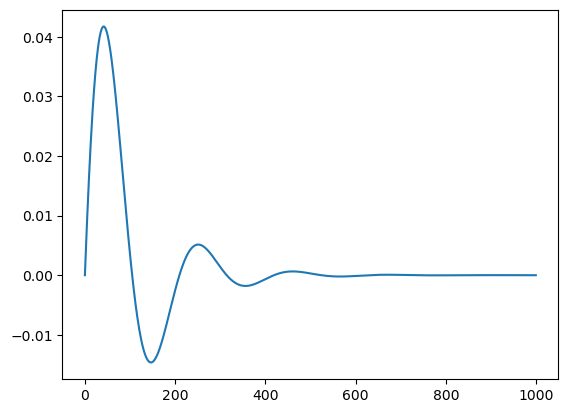

In [193]:
plt.plot(oscillator)

In [194]:
import scipy.stats.qmc as qmc

In [195]:
latent_sampler = qmc.LatinHypercube(d=3)
latent_sample = latent_sampler.random(n=18)

In [699]:
l_bounds = [-0.100005,0,0.1]
u_bounds = [-0.1, 0.0002,0.2]
latent = qmc.scale(latent_sample, l_bounds, u_bounds)

In [700]:
theta_sampler = qmc.LatinHypercube(d=1)
theta_sample = theta_sampler.random(n=500)

l_bounds = [0]
u_bounds = [10]
theta = qmc.scale(theta_sample, l_bounds, u_bounds)

In [701]:
y = np.zeros(500)
for i in range(500):
    x=int(theta[i]/0.01)
    y[i]=computeResponse(0.01,10,1,latent[0])[x]

In [702]:
options = np.linspace(0,18)

In [703]:
# X=torch.tensor(theta)
# y=torch.tensor(y)
# X_train_all, X_test, y_train_all, y_test = train_test_split(
#     X,
#     y,
#     test_size=200,
#     random_state=seed
# )
# nt=30
# reps = 10
# x=np.zeros(nt)
# R2=np.zeros(nt)
# MSE=np.zeros(nt)
# for i in range(nt):
#     for k in range(reps):
#         # split original dataset in training, validation and testing sets
#         X2=X_train_all
#         y2=y_train_all
#         X_train, X_test2, y_train, y_test2 = train_test_split(
#             X2,
#             y2,
#             train_size=(i+1)*3,
#             random_state=seed+i
#         )
#         x[i]=(i+1)*3
#         emulator=GPE.ensemble(X_train,y_train[:,None],mean_func='linear')
#         R2[i]+=emulator.R2(X_test,y_test[:,None])/reps
#         MSE[i]+=emulator.MSE(X_test,y_test[:,None])/reps

In [704]:
# plt.plot(x[:50]/2,R2[:50])

In [705]:
# plt.plot(x,MSE)

In [706]:
nsamp=40

In [707]:
theta_sampler = qmc.LatinHypercube(d=1)
theta_sample = theta_sampler.random(n=nsamp)

In [708]:
l_bounds = [0]
u_bounds = [10]
theta = qmc.scale(theta_sample, l_bounds, u_bounds)

In [709]:
latent[0]

array([-1.00003873e-01,  1.48475714e-04,  1.69132070e-01])

In [710]:
x

445

In [711]:
y = np.zeros(nsamp)
for i in range(nsamp):
    x=int(theta[i]/0.01)
    y[i]=computeResponse(0.01,10,1,latent[0])[x]
    

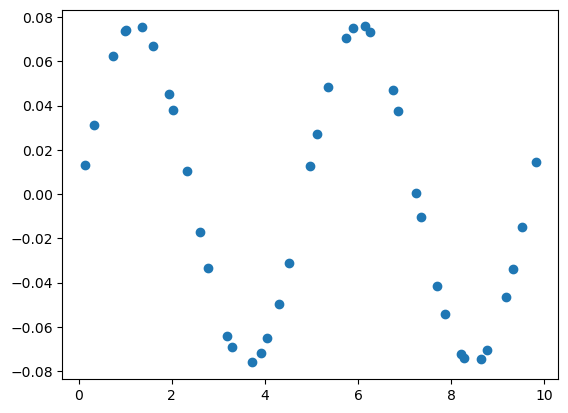

In [712]:
plt.plot(theta,y,'o')

In [713]:
# split original dataset in training, validation and testing sets
X=torch.tensor(theta)
y=torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=seed
)

In [714]:
emulator=GPE.ensemble(X_train,y_train[:,None],mean_func='linear')

0


In [715]:
emulator.R2(X_test,y_test[:,None])

tensor([1.0000], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [716]:
latent

array([[-1.00003873e-01,  1.48475714e-04,  1.69132070e-01],
       [-1.00001152e-01,  1.56717058e-04,  1.97827585e-01],
       [-1.00001072e-01,  3.27856810e-05,  1.28708355e-01],
       [-1.00003399e-01,  1.29401769e-04,  1.74749725e-01],
       [-1.00002562e-01,  1.06498381e-04,  1.81716893e-01],
       [-1.00000228e-01,  8.47270565e-05,  1.40432911e-01],
       [-1.00004571e-01,  1.68235178e-04,  1.64164362e-01],
       [-1.00004941e-01,  7.64264595e-05,  1.13231987e-01],
       [-1.00002888e-01,  6.20163266e-05,  1.00718060e-01],
       [-1.00001691e-01,  1.94620257e-04,  1.56372240e-01],
       [-1.00002024e-01,  1.74670034e-05,  1.10287203e-01],
       [-1.00001641e-01,  2.91936352e-06,  1.37868744e-01],
       [-1.00003985e-01,  9.78482549e-05,  1.27041199e-01],
       [-1.00000646e-01,  4.11911862e-05,  1.90319815e-01],
       [-1.00003302e-01,  1.81555709e-04,  1.85758211e-01],
       [-1.00002329e-01,  1.18106037e-04,  1.55325392e-01],
       [-1.00004215e-01,  5.26326697e-05

In [717]:
inputs=[]
for i,l in enumerate(latent):
    theta_sampler = qmc.LatinHypercube(d=1)
    theta_sample = theta_sampler.random(n=nsamp)
    l_bounds = [0]
    u_bounds = [10]
    theta = qmc.scale(theta_sample, l_bounds, u_bounds)
    inputs.append(theta)

In [718]:
oscillator[(inputs[1]/0.01).astype(int)]

array([[-5.79345880e-03],
       [-3.30309124e-06],
       [-3.50537678e-03],
       [ 7.69384455e-05],
       [ 6.41561898e-05],
       [ 3.74982406e-03],
       [ 4.88948669e-06],
       [-2.70877188e-05],
       [-1.17088484e-03],
       [-3.27787821e-06],
       [ 3.83470555e-02],
       [ 3.31850064e-03],
       [-4.18966044e-05],
       [-1.30058035e-02],
       [-9.01772746e-05],
       [ 4.31676925e-04],
       [ 4.41995817e-03],
       [-1.87325119e-04],
       [ 2.80108172e-05],
       [ 8.47763676e-04],
       [-2.17123130e-04],
       [-1.97057492e-06],
       [ 1.27457539e-05],
       [ 6.81345143e-08],
       [-1.04107637e-05],
       [-1.71151269e-03],
       [ 6.31926439e-04],
       [ 9.09114411e-06],
       [-2.41675716e-05],
       [ 4.22584347e-03],
       [ 7.66940308e-03],
       [-1.16933969e-05],
       [-7.36988777e-05],
       [ 3.59619184e-06],
       [-1.78160141e-03],
       [ 3.40718367e-04],
       [-1.42327383e-02],
       [-2.00318396e-04],
       [ 3.5

In [719]:
response = computeResponse(0.01,10,1,latent[0])
theta=(inputs[i]/0.01).astype(int)

In [720]:
response[theta]

array([[ 0.01549867],
       [-0.01401068],
       [-0.04807432],
       [ 0.07076542],
       [ 0.04704507],
       [-0.07622025],
       [-0.05897827],
       [-0.04954474],
       [ 0.03881303],
       [-0.00226187],
       [ 0.07652926],
       [ 0.0105182 ],
       [ 0.07333686],
       [-0.01801928],
       [-0.0393715 ],
       [-0.03476147],
       [-0.07554049],
       [ 0.05078666],
       [-0.06501091],
       [ 0.06653508],
       [ 0.06085978],
       [-0.07621313],
       [-0.06812309],
       [-0.05331033],
       [ 0.06913734],
       [ 0.00583382],
       [-0.07619753],
       [ 0.01738801],
       [ 0.06441708],
       [ 0.07394397],
       [ 0.03514993],
       [-0.02586123],
       [ 0.02226362],
       [-0.0697073 ],
       [ 0.07425312],
       [ 0.06007433],
       [ 0.0416238 ],
       [-0.04571423],
       [-0.02276436],
       [ 0.01685955]])

In [721]:
outputs = []
for i,l in enumerate(latent):
    response = computeResponse(0.01,10,1,l)
    theta=(inputs[i]/0.01).astype(int)
    outputs.append(response[theta])

In [722]:
outputs

[array([[-0.06453176],
        [ 0.07084124],
        [-0.07395586],
        [ 0.05653799],
        [-0.07475143],
        [ 0.07643531],
        [ 0.00864408],
        [-0.04885268],
        [ 0.0764518 ],
        [ 0.00085765],
        [-0.04519345],
        [-0.07639851],
        [ 0.07664468],
        [-0.04801565],
        [-0.06023337],
        [ 0.07471198],
        [-0.01315267],
        [-0.07594687],
        [-0.04164346],
        [ 0.03777434],
        [-0.01797964],
        [ 0.02029164],
        [ 0.04573328],
        [ 0.05750244],
        [-0.01106137],
        [ 0.03354917],
        [ 0.04995896],
        [ 0.00499624],
        [-0.00242556],
        [-0.07083953],
        [-0.05938129],
        [-0.05672422],
        [-0.06812309],
        [ 0.07288136],
        [ 0.07340406],
        [-0.00523677],
        [-0.00938915],
        [ 0.05371418],
        [ 0.0705642 ],
        [ 0.02785154]]),
 array([[ 0.03298985],
        [ 0.06548531],
        [ 0.07101814],
        [

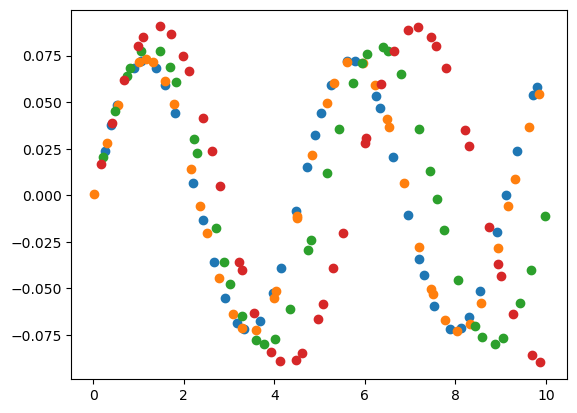

In [723]:
plt.plot(inputs[13],outputs[13],'o')
plt.plot(inputs[14],outputs[14],'o')
plt.plot(inputs[15],outputs[15],'o')
plt.plot(inputs[16],outputs[16],'o')

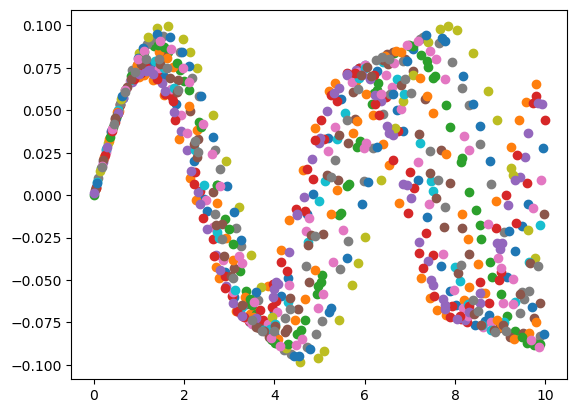

In [724]:
for i in range(len(outputs)):
    plt.plot(inputs[i],outputs[i],'o')

In [725]:
R2_mean = np.zeros((1,len(inputs)) )
R2_std = np.zeros((1,len(inputs))) 
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear')
    mean,std=emulator.R2_sample(X_test,y_test,100)
    R2_mean[:,i]=mean
    R2_std[:,i]=std

0


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [726]:
y_train.shape

torch.Size([32, 1])

Text(0, 0.5, '$R^2$')

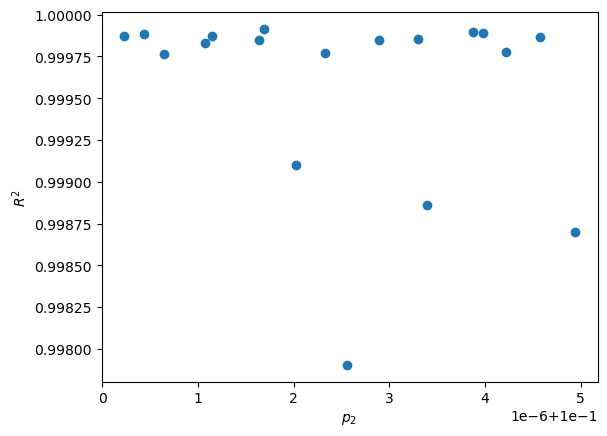

In [727]:
plt.plot(-latent[:,0],R2_mean.T,'o')
#plt.legend(['dif','end','mean'])
plt.xlabel('$p_2$')
plt.ylabel('$R^2$')

In [728]:
R2_mean = np.zeros((1,len(inputs)) )
MSE = np.zeros((1,len(inputs))) 
yvar=np.zeros((1,len(inputs))) 
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear')
    mean=emulator.R2(X_test,y_test)
    R2_mean[:,i]=mean.detach().numpy()
    M=emulator.MSE(X_test,y_test)
    MSE[:,i]=M.detach().numpy()
    yvar[:,i]=y_test.var()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


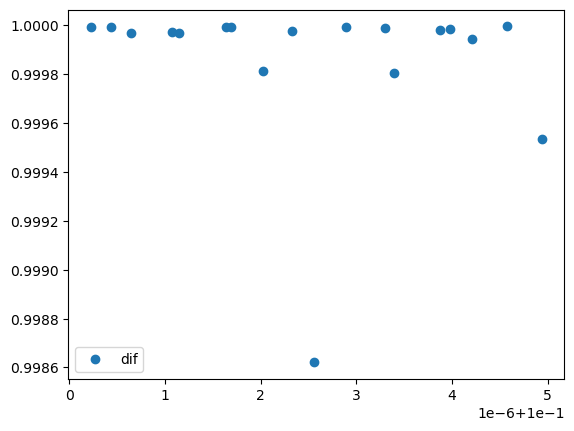

In [729]:
plt.plot(-latent[:,0],R2_mean.T,'o')
plt.legend(['dif','end','mean'])

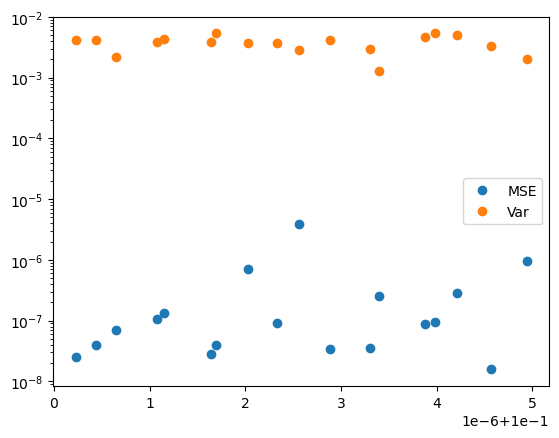

In [730]:
plt.plot(-latent[:,0],MSE.T,'o')
plt.plot(-latent[:,0],yvar.T,'o')
plt.legend(['MSE','Var'])
plt.yscale('log')

In [731]:
R2_mean

array([[0.99998111, 0.99996942, 0.9999727 , 0.99980325, 0.99862105,
        0.99999398, 0.99999517, 0.99953324, 0.99999189, 0.99999273,
        0.99981171, 0.99999273, 0.9999826 , 0.99996811, 0.99998832,
        0.99997568, 0.99994385, 0.99999064]])

In [732]:
1-MSE.T/y_test.var()

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [0.9991],
        [1.0000],
        [1.0000],
        [0.9998],
        [1.0000],
        [1.0000],
        [0.9998],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [1.0000]], dtype=torch.float64)

In [733]:
large_input = np.array(inputs[0:17]).reshape(17*nsamp,1)

In [734]:
latent[0:17]

array([[-1.00003873e-01,  1.48475714e-04,  1.69132070e-01],
       [-1.00001152e-01,  1.56717058e-04,  1.97827585e-01],
       [-1.00001072e-01,  3.27856810e-05,  1.28708355e-01],
       [-1.00003399e-01,  1.29401769e-04,  1.74749725e-01],
       [-1.00002562e-01,  1.06498381e-04,  1.81716893e-01],
       [-1.00000228e-01,  8.47270565e-05,  1.40432911e-01],
       [-1.00004571e-01,  1.68235178e-04,  1.64164362e-01],
       [-1.00004941e-01,  7.64264595e-05,  1.13231987e-01],
       [-1.00002888e-01,  6.20163266e-05,  1.00718060e-01],
       [-1.00001691e-01,  1.94620257e-04,  1.56372240e-01],
       [-1.00002024e-01,  1.74670034e-05,  1.10287203e-01],
       [-1.00001641e-01,  2.91936352e-06,  1.37868744e-01],
       [-1.00003985e-01,  9.78482549e-05,  1.27041199e-01],
       [-1.00000646e-01,  4.11911862e-05,  1.90319815e-01],
       [-1.00003302e-01,  1.81555709e-04,  1.85758211e-01],
       [-1.00002329e-01,  1.18106037e-04,  1.55325392e-01],
       [-1.00004215e-01,  5.26326697e-05

In [735]:
mean=emulator.R2(X_test,y_test)

M=emulator.MSE(X_test,y_test)


In [736]:
modeweights1 = np.repeat(latent[0:17,0],nsamp)

In [737]:
modeweights2= np.repeat(latent[0:17,1],nsamp)

In [738]:
large_input = np.concatenate((large_input,modeweights1[:,None],modeweights2[:,None]),axis=1)

In [739]:
large_output = np.array(outputs[0:17]).reshape(17*nsamp,1)

In [740]:
leftout_input = np.concatenate((inputs[17],np.repeat(latent[17,0],nsamp)[:,None],np.repeat(latent[17,1],nsamp)[:,None]),axis=1)

In [741]:
large_input.shape

(680, 3)

In [742]:
# split original dataset in training, validation and testing sets
X=torch.tensor(large_input)
y=torch.tensor(large_output)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=300,
    random_state=seed
)

emulator=GPE.ensemble(X_train,y_train,mean_func='linear')

emulator.R2(X_test,y_test)

0


tensor([0.9968], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [743]:
emulator.R2(torch.tensor(leftout_input),torch.tensor(outputs[17]))

tensor([0.1754], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [744]:
modeweights2.shape

(680,)

In [745]:
780/nsamp

19.5

In [746]:
340/nsamp

8.5

In [747]:
latent.shape

(18, 3)

In [748]:
R2_in = torch.zeros((18,1))
R2_out = torch.zeros((18,1))
MSE_out=torch.zeros((18,1))
for i in range(18):
    
    
    
    large_input = np.array(inputs[0:i]+inputs[i+1:18]).reshape(17*nsamp,1)

    latent2=latent.copy()
    latent2=np.delete(latent2,i,axis=0)

    modeweights = np.repeat(latent2,nsamp,axis=0)

    large_input = np.concatenate((large_input,modeweights),axis=1)

    large_output = np.array(outputs[0:i]+outputs[i+1:18]).reshape(17*nsamp,1)
    
    leftout_input=torch.tensor(np.concatenate((inputs[i],np.repeat(latent[[i]],nsamp,axis=0)),axis=1))
    leftout_output=torch.tensor(outputs[i])
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(large_input)
    y=torch.tensor(large_output)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=300,
        random_state=seed
    )

    emulator=GPE.ensemble(X_train,y_train,mean_func='linear',training_iter=1000)

    R2_in[i]=emulator.R2(X_test,y_test)

    R2_out[i]=emulator.R2(leftout_input,leftout_output)
    MSE_out[i]=emulator.MSE(leftout_input,leftout_output)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


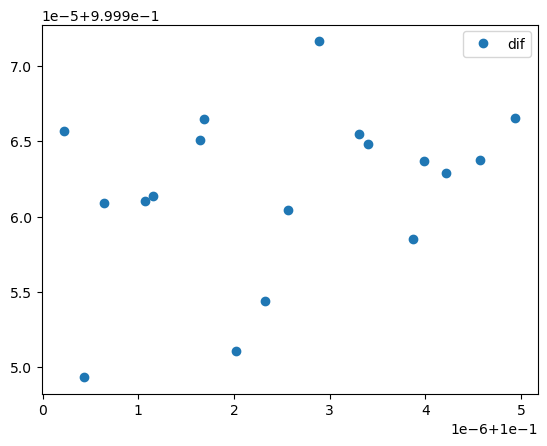

In [749]:
plt.plot(-latent[:,0],R2_in.detach().numpy(),'o')
plt.legend(['dif','end','mean'])

Text(0, 0.5, '$R^2$')

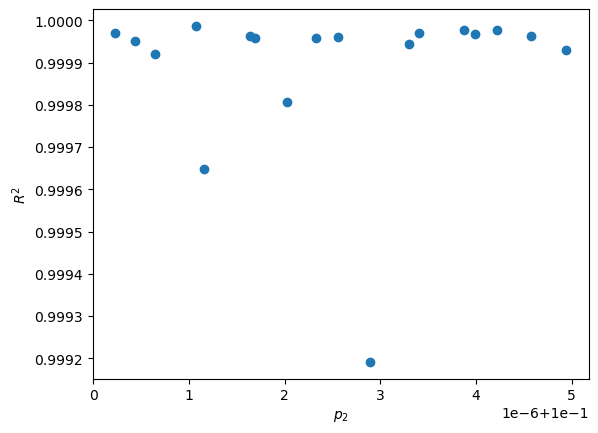

In [750]:
plt.plot(-latent[:,0],R2_out.detach().numpy(),'o')
plt.xlabel('$p_2$')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

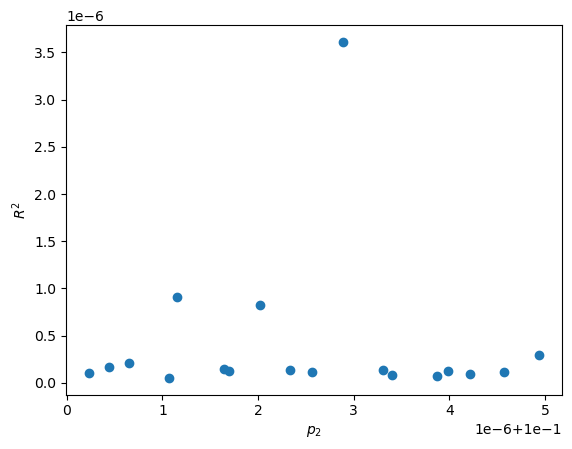

In [751]:
plt.plot(-latent[:,0],MSE_out.detach().numpy(),'o')
plt.xlabel('$p_2$')
plt.ylabel('$R^2$')

In [752]:
inputs.copy()

[array([[8.02895442],
        [5.7491322 ],
        [8.6550164 ],
        [5.4798122 ],
        [3.45850348],
        [1.13827632],
        [7.16749357],
        [4.3069603 ],
        [6.00513578],
        [4.84340237],
        [2.90929878],
        [8.44251257],
        [1.26087644],
        [9.14217668],
        [3.11070302],
        [5.87736382],
        [7.38250202],
        [3.73204347],
        [7.69508534],
        [6.8505593 ],
        [9.48280152],
        [2.21851044],
        [0.49975368],
        [0.65469099],
        [4.72185858],
        [5.18126539],
        [6.70653889],
        [0.05217802],
        [2.44709104],
        [8.75114233],
        [4.15420517],
        [7.8906271 ],
        [3.9940577 ],
        [0.96654207],
        [6.26015364],
        [9.61021333],
        [2.51062406],
        [1.82003931],
        [1.52464134],
        [9.95238655]]),
 array([[1.89743501],
        [9.78290809],
        [1.10509922],
        [6.75896022],
        [6.52601678],
        

In [753]:
X_train

tensor([[ 9.7373e+00, -1.0000e-01,  8.4727e-05,  1.4043e-01],
        [ 6.9870e+00, -1.0000e-01,  9.7848e-05,  1.2704e-01],
        [ 6.2125e+00, -1.0000e-01,  1.2940e-04,  1.7475e-01],
        ...,
        [ 4.7185e+00, -1.0000e-01,  4.1191e-05,  1.9032e-01],
        [ 3.5274e+00, -1.0000e-01,  1.0650e-04,  1.8172e-01],
        [ 2.0643e+00, -1.0000e-01,  1.0650e-04,  1.8172e-01]],
       dtype=torch.float64)

In [754]:
def proxy(a,y_train,m0):
    a=torch.tensor(a)
    res = ((a*m0-y_train)**2).mean().detach().numpy()
    return res

In [755]:
import scipy

In [756]:
inputs

[array([[8.02895442],
        [5.7491322 ],
        [8.6550164 ],
        [5.4798122 ],
        [3.45850348],
        [1.13827632],
        [7.16749357],
        [4.3069603 ],
        [6.00513578],
        [4.84340237],
        [2.90929878],
        [8.44251257],
        [1.26087644],
        [9.14217668],
        [3.11070302],
        [5.87736382],
        [7.38250202],
        [3.73204347],
        [7.69508534],
        [6.8505593 ],
        [9.48280152],
        [2.21851044],
        [0.49975368],
        [0.65469099],
        [4.72185858],
        [5.18126539],
        [6.70653889],
        [0.05217802],
        [2.44709104],
        [8.75114233],
        [4.15420517],
        [7.8906271 ],
        [3.9940577 ],
        [0.96654207],
        [6.26015364],
        [9.61021333],
        [2.51062406],
        [1.82003931],
        [1.52464134],
        [9.95238655]]),
 array([[1.89743501],
        [9.78290809],
        [1.10509922],
        [6.75896022],
        [6.52601678],
        

In [757]:
t_size = 30
reps = 1
MSE = np.zeros((18,17,1))
R2 = np.zeros((18,17,1))
for i in range(18):

    X0 = torch.tensor(inputs[i])
    Y0 = torch.tensor(outputs[i])
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)
    
    inputs2 = inputs.copy()
    inputs2.pop(i)
    outputs2 = outputs.copy()
    outputs2.pop(i)
    
    for j in (range(17)):
        inputData_1 = inputs2[j]
        outputData_1 = outputs2[j]

        X1 = torch.tensor(inputData_1)
        Y1 = torch.tensor(outputData_1)
        # split original dataset in training, validation and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X1,
            Y1,
            test_size=0.1,
            random_state=seed
        )
        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
            #m0 = emulator_0.predict(X_train[a,:])
            #y_adjust = torch.tensor(y_train[a] - m0)
            delta_1 = GPE.ensemble(X_train[a,:],y_train[a,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulator_0])
            #MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            #R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps
            MSE[i,j,:] += delta_1.MSE(X_test,y_test).detach().numpy()
            R2[i,j,:] += delta_1.R2(X_test,y_test).detach().numpy()


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [758]:
R2

array([[[0.99999475],
        [0.9999181 ],
        [0.99990363],
        [0.99998217],
        [0.99998569],
        [0.99998857],
        [0.99998368],
        [0.99997993],
        [0.99999563],
        [0.99996922],
        [0.99995558],
        [0.99998929],
        [0.99996998],
        [0.9999989 ],
        [0.99998909],
        [0.99966708],
        [0.99999766]],

       [[0.99998499],
        [0.99991322],
        [0.99963138],
        [0.99998303],
        [0.99999597],
        [0.99998247],
        [0.99996964],
        [0.99997276],
        [0.99999137],
        [0.99997912],
        [0.99998641],
        [0.99998773],
        [0.99995233],
        [0.99988812],
        [0.9999565 ],
        [0.99953976],
        [0.99999607]],

       [[0.9999842 ],
        [0.99999352],
        [0.9991105 ],
        [0.9998005 ],
        [0.99999319],
        [0.99998596],
        [0.999986  ],
        [0.99997388],
        [0.99999331],
        [0.99982431],
        [0.99998571],
      

In [759]:
t_size = 20
reps = 1
MSE = np.zeros((18,1))
R2 = np.zeros((18,1))
emulators=[]
for i in range(18):
    

    X0 = torch.tensor(inputs[i])
    Y0 = torch.tensor(outputs[i])
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)
    emulators.append(emulator_0)
    
    
    
for i in (range(18)):
    
    emulators2 = emulators.copy()
    emulators2.pop(i)
    print(len(emulators2))
    
    inputData_1 = inputs[i]
    outputData_1 = outputs[i]

    X1 = torch.tensor(inputData_1)
    Y1 = torch.tensor(outputData_1)
    # split original dataset in training, validation and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X1,
        Y1,
        test_size=0.1,
        random_state=seed
    )
    for k in range(reps):
        a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
        #m0 = emulator_0.predict(X_train[a,:])
        #y_adjust = torch.tensor(y_train[a] - m0)
        delta_1 = GPE.ensemble(X_train[a,:],y_train[a,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators)
        #MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
        #R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps
        MSE[i,:] += delta_1.MSE(X_test,y_test).detach().numpy()
        R2[i,:] += delta_1.R2(X_test,y_test).detach().numpy()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
17
0
17
0


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0
17
0


In [760]:
R2

array([[0.99999459],
       [0.99996283],
       [0.99992696],
       [0.99985024],
       [0.99594491],
       [0.99998794],
       [0.99913788],
       [0.99834739],
       [0.99997987],
       [0.9999721 ],
       [0.99997819],
       [0.99998576],
       [0.99997474],
       [0.9979422 ],
       [0.99993254],
       [0.99995353],
       [0.99638475],
       [0.99978932]])

In [761]:
latent[:,0]

array([-0.10000387, -0.10000115, -0.10000107, -0.1000034 , -0.10000256,
       -0.10000023, -0.10000457, -0.10000494, -0.10000289, -0.10000169,
       -0.10000202, -0.10000164, -0.10000398, -0.10000065, -0.1000033 ,
       -0.10000233, -0.10000421, -0.10000044])

In [762]:
R2.mean(axis=0)

array([0.99928032])

In [763]:
R2

array([[0.99999459],
       [0.99996283],
       [0.99992696],
       [0.99985024],
       [0.99594491],
       [0.99998794],
       [0.99913788],
       [0.99834739],
       [0.99997987],
       [0.9999721 ],
       [0.99997819],
       [0.99998576],
       [0.99997474],
       [0.9979422 ],
       [0.99993254],
       [0.99995353],
       [0.99638475],
       [0.99978932]])

Text(0, 0.5, '$R^2$')

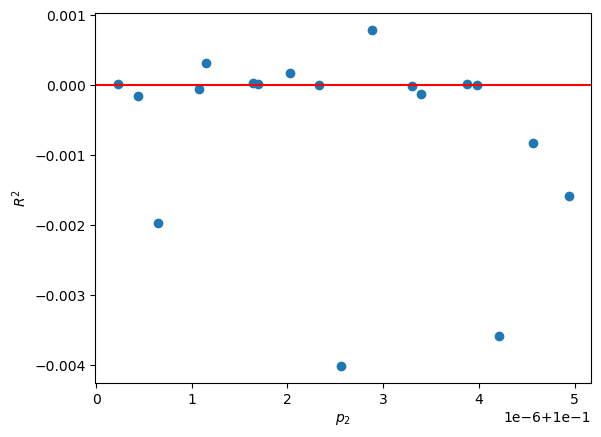

In [764]:
fig, ax = plt.subplots()


ax.scatter(-latent[:,0],R2[:,0]-R2_out.detach().numpy()[:,0])
plt.axhline(y=0, color='r', linestyle='-')
#ax.scatter(latent[9:,0],R2_out.detach().numpy()[9:,2])

#ax.scatter(latent,R2.mean(axis=1)[:,1])
#ax.scatter(latent,R2_out.detach().numpy()[:,1])

#ax.scatter(latent,R2.mean(axis=1)[:,2])
#ax.scatter(latent,R2_out.detach().numpy()[:,2])

#plt.errorbar(latent,R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


#ax.scatter(latent,R2.mean(axis=1)[:,1])
#plt.errorbar(latent,R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


#ax.scatter(latent,R2.mean(axis=1)[:,2])
#plt.errorbar(latent,R2.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.xlabel('$p_2$')
plt.ylabel('$R^2$')

In [765]:
R2[:,0]

array([0.99999459, 0.99996283, 0.99992696, 0.99985024, 0.99594491,
       0.99998794, 0.99913788, 0.99834739, 0.99997987, 0.9999721 ,
       0.99997819, 0.99998576, 0.99997474, 0.9979422 , 0.99993254,
       0.99995353, 0.99638475, 0.99978932])

In [766]:
R2_out.detach().numpy()[:,0]

array([0.99997735, 0.99964905, 0.99998695, 0.99997103, 0.9999598 ,
       0.99997133, 0.99996287, 0.9999305 , 0.9991911 , 0.9999592 ,
       0.9998079 , 0.9999622 , 0.9999686 , 0.9999201 , 0.9999445 ,
       0.9999576 , 0.9999774 , 0.9999514 ], dtype=float32)

In [767]:
import time

In [768]:
Xs=inputs

In [769]:
Ys =outputs

In [770]:
Xs[i].shape

(40, 1)

In [771]:
def proxy(a,y_train,m0,output):
    m_t = (m0-y_train.mean(axis=0))/y_train.std(axis=0)
    y_t = (y_train-y_train.mean(axis=0))/y_train.std(axis=0)
    a=torch.tensor(a)
    res = ((a*m_t-y_t)**2).mean(axis=0).detach().numpy()
    return res[output]

In [772]:
def proxy_cohort(a,y_test,emulators,x_test,output):
    a=torch.tensor(a)
    res=torch.zeros((y_test.shape[1]))
    m0=torch.zeros(y_test.shape)
    for i in range(len(emulators)):
        m=emulators[i].predict(x_test)
        m_t=emulators[i].normalise_output(m)
        y_t=emulators[i].normalise_output(y_test)
        m0+=a[i]*m_t
    res += ((m0-y_t)**2).mean(axis=0).detach().numpy()
    return res[output]

In [773]:
def m0_mat(y_test,emulators,x_test,output):

    m0=torch.zeros((y_test.shape[0],len(emulators)))
    for i in range(len(emulators)):
        m0[:,i]=(emulators[i].predict(x_test)[:,output]-y_train.mean(axis=0)[output])/y_train.std(axis=0)[output]


    return m0

In [774]:
import scipy

In [775]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

In [776]:
model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=False)),
    ('lasso', LassoCV(n_alphas=1000,max_iter=50000))
])


In [777]:
t_size = 20
reps = 1
MSE = np.zeros((18,1))
R2 = np.zeros((18,1))
emulators=[]
for i in range(18):
    

    X0 = torch.tensor(inputs[i])
    Y0 = torch.tensor(outputs[i])
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)
    emulators.append(emulator_0)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [778]:
y_train

tensor([[ 0.0600],
        [-0.0420],
        [-0.0803],
        [-0.0071],
        [-0.0562],
        [ 0.0419],
        [ 0.0795],
        [-0.0680],
        [ 0.0262],
        [ 0.0317],
        [-0.0615],
        [ 0.0088],
        [ 0.0804],
        [ 0.0813],
        [ 0.0252],
        [-0.0420],
        [ 0.0801],
        [ 0.0685],
        [-0.0737],
        [ 0.0169],
        [-0.0488],
        [-0.0800],
        [-0.0113],
        [-0.0803],
        [ 0.0804],
        [-0.0409],
        [-0.0692],
        [ 0.0107],
        [ 0.0611],
        [-0.0259],
        [ 0.0441],
        [-0.0723],
        [ 0.0751],
        [ 0.0728],
        [-0.0238],
        [ 0.0205]], dtype=torch.float64)

In [779]:
import time

In [782]:
reps=1
n=20
R2=torch.zeros(7,1,reps)
ISE=torch.zeros(7,1,reps)
Ti=torch.zeros(7,reps)

for k in range(len(emulators)):
    emulators2=emulators.copy()
    emulators2.pop(k)
    print(len(emulators2))
    X_train, X_test, y_train, y_test = train_test_split(
                torch.tensor(Xs[k]).float(),
                torch.tensor(Ys[k]).float(),
                test_size=0.1,
                random_state=seed
            )
    for i in range(reps):

        b=np.random.choice(range(X_train.shape[0]),n,replace=False)

#         start = time.time()
#         model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
#         end = time.time()
#         R2[0,:,i]+=model_f.R2(X_test,y_test)/(len(emulators))
#         ISE[0,:,i]+=model_f.ISE(X_test,y_test)/(len(emulators))
        
#         Ti[0,i]+=(end-start)/(len(emulators))

        
#         em=np.random.randint(len(emulators2))
#         start = time.time()
#         model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1]]))
#         end = time.time()
#         R2[1,:,i]+=model_dc_1.R2(X_test,y_test)/(len(emulators))
#         ISE[1,:,i]+=model_dc_1.ISE(X_test,y_test)/(len(emulators))
#         print(model_dc_1.R2(X_test,y_test))
#         print(R2[1])
        
#         Ti[1,i]+=(end-start)/(len(emulators))

#         start = time.time()
#         m0 = emulators2[0].predict(X_train[b,:])
#         a_d=np.zeros((y_train.shape[1],1))
#         for l in range(y_train.shape[1]):
#             result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
#             print(result.x)
#             a_d[l]=result.x
#         a_d=torch.tensor(a_d)
#         print(a_d)
#         model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=a_d)
#         end = time.time()
#         R2[2,:,i]+=model_dc_reg.R2(X_test,y_test)/(len(emulators))
#         ISE[2,:,i]+=model_dc_reg.ISE(X_test,y_test)/(len(emulators))
        
#         Ti[2,i]+=(end-start)/(len(emulators))

#         start = time.time()
#         model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]])
#         end = time.time()
#         R2[3,:,i]+=model_dc_learned.R2(X_test,y_test)/(len(emulators))
#         ISE[3,:,i]+=model_dc_learned.ISE(X_test,y_test)/(len(emulators))
        
#         Ti[3,i]+=(end-start)/(len(emulators))

#         start = time.time()
#         model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
#         end = time.time()
#         R2[4,:,i]+=model_dc_all.R2(X_test,y_test)/(len(emulators))
#         ISE[4,:,i]+=model_dc_all.ISE(X_test,y_test)/(len(emulators))
        
#         Ti[4,i]+=(end-start)/(len(emulators))

        start = time.time()
        a_d=torch.zeros((y_train.shape[1],len(emulators2)))
        for j in range(y_train.shape[1]):
            m0=m0_mat(y_train[b],emulators2,X_train[b],j)
            # fit to an order-3 polynomial data
            y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
            model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
            a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)
        print(a_d)

        model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
        end = time.time()
        R2[5,:,i]+=model_dc_lasso.R2(X_test,y_test)/(len(emulators))
        ISE[5,:,i]+=model_dc_lasso.ISE(X_test,y_test)/(len(emulators))
        
        Ti[5,i]+=(end-start)/(len(emulators))

        start = time.time()
        model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
        end = time.time()
        R2[6,:,i]+=model_dc_lasso_learned.R2(X_test,y_test)/(len(emulators))
        ISE[6,:,i]+=model_dc_lasso_learned.ISE(X_test,y_test)/(len(emulators))
        
        Ti[6,i]+=(end-start)/(len(emulators))
        
    print(R2*(len(emulators)/(k+1)))

17
tensor([[ 0.0000,  0.0000,  0.4737,  0.0000,  0.0000,  0.5304, -0.0000, -0.0027,
          0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
          0.0000]])
0
0
tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[1.0000]],

        [[0.9999]]], grad_fn=<MulBackward0>)
17
tensor([[-0.2954,  0.0000, -0.0000, -0.0000, -0.0000, -0.0648,  0.0118, -0.0000,
         -0.0000,  0.0000,  0.0000,  0.0199,  1.3006,  0.0000, -0.0000,  0.0078,
         -0.0000]])
0
0


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[1.0000]],

        [[1.0000]]], grad_fn=<MulBackward0>)
17
tensor([[-0.0000, -0.0038, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
          0.0000,  0.0000,  0.1746,  0.8327, -0.0000, -0.0000,  0.0000,  0.0000,
          0.0000]])
0
0
tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[1.0000]],

        [[0.9999]]], grad_fn=<MulBackward0>)
17
tensor([[ 5.6954e-01,  0.0000e+00, -0.0000e+00,  4.3797e-01,  0.0000e+00,
          0.0000e+00, -0.0000e+00, -8.1391e-05,  0.0000e+00, -5.5803e-03,
         -0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -0.0000e+00,  0.0000e+00]])
0
0
tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.9999]],

        [[0.9998]]], grad_fn=<MulBackward0>)
17
tensor([[0.0000, 0.0000, -0.0

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.9999]],

        [[0.9998]]], grad_fn=<MulBackward0>)
17
tensor([[ 0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -0.0000e+00, -1.1280e-02,  1.2531e-01, -0.0000e+00,
          8.8581e-01,  0.0000e+00, -0.0000e+00, -0.0000e+00,  3.6934e-04,
          0.0000e+00,  2.3766e-03]])
0
0
tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[1.0000]],

        [[0.9998]]], grad_fn=<MulBackward0>)
17
tensor([[ 0.6026,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0068,
          0.3643, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0410, -0.0000,
          0.0000]])
0
0
tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.9881]],

        [[0.9998]]], grad_fn=<MulBackward0>)
17
tensor([[-0.0000, -0.0063,  0

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.

In [781]:
R2*(len(emulators)/(k+1))

tensor([[[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[1.0000]],

        [[0.6667]]], grad_fn=<MulBackward0>)

In [ ]:
R2

In [ ]:
R2.mean(axis=2)

In [ ]:
results=pd.DataFrame(torch.cat((R2.mean(axis=2).T,Ti.mean(axis=1)[None])).T.detach().numpy())

results.index=['$f_1$','$\delta_1$, a=1','$\delta_1$, regression a','$\delta_1$, learned a','$\delta_c$, all','$\delta_c$, lasso','$\delta_c$, lasso indicator']

results.columns=['u','Time']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [ ]:
a_d=torch.zeros((y_train.shape[1],len(emulators2)))
for j in range(y_train.shape[1]):
    m0=m0_mat(y_train[b],emulators2,X_train[b],j)
    # fit to an order-3 polynomial data
    y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
    model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
    a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)

In [ ]:
a_d

In [ ]:
R2.mean(axis=2).shape

In [ ]:
Ti.mean(axis=1).shape

In [ ]:
a_d

In [ ]:
R2_out.detach().numpy()[:,0]

In [ ]:

ax.scatter(-latent[:,0],R2.mean(axis=1)[:,0])
plt.errorbar(-latent[:,0],R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])



plt.xlabel('$p_2$')
plt.ylabel('$R^2$')
#plt.yscale('log')

In [ ]:

ax.scatter(-latent[:,0],MSE.mean(axis=1)[:,0])
#plt.errorbar(latent[:,0],MSE.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])



plt.xlabel('$p_2$')
plt.ylabel('$R^2$')
#plt.yscale('log')

In [ ]:
X0 = torch.tensor(inputs[0])
Y0 = torch.tensor(outputs[0])
emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

In [ ]:
X0.shape[0]*0.05

In [ ]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE = np.zeros((n,m,1))
R2 = np.zeros((n,m,1))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            y_adjust = torch.tensor(y_train[b] - m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


In [ ]:
x = np.linspace(2,38,18)

x

y = np.linspace(2,40,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2[level:,level:,0],origin='lower',levels=500)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

In [130]:
def proxy(a,y_train,m0,output):
    a=torch.tensor(a)
    res = ((a*m0-y_train)**2).mean(axis=1).detach().numpy()
    return res[output]

In [131]:
import scipy

In [132]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE_a = np.zeros((n,m,1))
R2_a = np.zeros((n,m,1))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            a_d=np.zeros(y_train.shape[1])
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x

            a_d=torch.tensor(a_d)
            print(a_d)
            
            y_adjust = torch.tensor(y_train[b] - a_d*m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE_a[i,k,:] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2_a[i,k,:] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps

0
[1.24066154]
tensor([1.2407], dtype=torch.float64)
0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/1148931251.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - a_d*m0)
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/1148931251.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_a[i,k,:] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/1148931251.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

0
[0.29930915]
tensor([0.2993], dtype=torch.float64)
0
0
[0.30208411]
tensor([0.3021], dtype=torch.float64)
0
0
[0.03561517]
tensor([0.0356], dtype=torch.float64)
0
0
[0.10378384]
tensor([0.1038], dtype=torch.float64)
0
0
[0.32773211]
tensor([0.3277], dtype=torch.float64)
0
0
[0.31489922]
tensor([0.3149], dtype=torch.float64)
0
0
[1.0540279]
tensor([1.0540], dtype=torch.float64)
0
0
[3.06547928]
tensor([3.0655], dtype=torch.float64)
0
0
[0.05704001]
tensor([0.0570], dtype=torch.float64)
0
0
[0.29839577]
tensor([0.2984], dtype=torch.float64)
0
0
[0.64825125]
tensor([0.6483], dtype=torch.float64)
0
0
[0.05958042]
tensor([0.0596], dtype=torch.float64)
0
0
[0.21936197]
tensor([0.2194], dtype=torch.float64)
0
0
[0.62076582]
tensor([0.6208], dtype=torch.float64)
0
0
[0.30919249]
tensor([0.3092], dtype=torch.float64)
0
0
[0.45918038]
tensor([0.4592], dtype=torch.float64)
0
0
[1.1192014]
tensor([1.1192], dtype=torch.float64)
0
0
[0.67379978]
tensor([0.6738], dtype=torch.float64)
0
0
[0.1183103

0
[0.17983769]
tensor([0.1798], dtype=torch.float64)
0
0
[0.03315623]
tensor([0.0332], dtype=torch.float64)
0
0
[0.69606571]
tensor([0.6961], dtype=torch.float64)
0
0
[1.34031129]
tensor([1.3403], dtype=torch.float64)
0
0
[1.11031591]
tensor([1.1103], dtype=torch.float64)
0
0
[1.24382904]
tensor([1.2438], dtype=torch.float64)
0
0
[1.54938691]
tensor([1.5494], dtype=torch.float64)
0
0
[0.27867917]
tensor([0.2787], dtype=torch.float64)
0
0
[1.33984476]
tensor([1.3398], dtype=torch.float64)
0
0
[0.00814981]
tensor([0.0081], dtype=torch.float64)
0
0
[0.01219228]
tensor([0.0122], dtype=torch.float64)
0
0
[0.10392925]
tensor([0.1039], dtype=torch.float64)
0
0
[0.12562092]
tensor([0.1256], dtype=torch.float64)
0
0
[0.32258839]
tensor([0.3226], dtype=torch.float64)
0
0
[0.03423767]
tensor([0.0342], dtype=torch.float64)
0
0
[0.82643521]
tensor([0.8264], dtype=torch.float64)
0
0
[1.34148853]
tensor([1.3415], dtype=torch.float64)
0
0
[0.71027526]
tensor([0.7103], dtype=torch.float64)
0
0
[0.08385

0
[0.08492904]
tensor([0.0849], dtype=torch.float64)
0
0
[0.01875169]
tensor([0.0188], dtype=torch.float64)
0
0
[1.68181443]
tensor([1.6818], dtype=torch.float64)
0
0
[0.08658729]
tensor([0.0866], dtype=torch.float64)
0
0
[1.00300329]
tensor([1.0030], dtype=torch.float64)
0
0
[0.05477945]
tensor([0.0548], dtype=torch.float64)
0
0
[0.18831741]
tensor([0.1883], dtype=torch.float64)
0
0
[1.05867622]
tensor([1.0587], dtype=torch.float64)
0
0
[0.15413042]
tensor([0.1541], dtype=torch.float64)
0
0
[1.10744681]
tensor([1.1074], dtype=torch.float64)
0
0
[1.4335888]
tensor([1.4336], dtype=torch.float64)
0
0
[0.07638537]
tensor([0.0764], dtype=torch.float64)
0
0
[0.05272739]
tensor([0.0527], dtype=torch.float64)
0
0
[0.1275948]
tensor([0.1276], dtype=torch.float64)
0
0
[0.01212005]
tensor([0.0121], dtype=torch.float64)
0
0
[0.04931388]
tensor([0.0493], dtype=torch.float64)
0
0
[1.37239449]
tensor([1.3724], dtype=torch.float64)
0
0
[0.52633104]
tensor([0.5263], dtype=torch.float64)
0
0
[0.0667315

0
[0.26947568]
tensor([0.2695], dtype=torch.float64)
0
0
[0.83261613]
tensor([0.8326], dtype=torch.float64)
0
0
[1.72653139]
tensor([1.7265], dtype=torch.float64)
0
0
[0.18686861]
tensor([0.1869], dtype=torch.float64)
0
0
[0.25503113]
tensor([0.2550], dtype=torch.float64)
0
0
[0.06724038]
tensor([0.0672], dtype=torch.float64)
0
0
[0.03386637]
tensor([0.0339], dtype=torch.float64)
0
0
[0.38054606]
tensor([0.3805], dtype=torch.float64)
0
0
[0.16989834]
tensor([0.1699], dtype=torch.float64)
0
0
[0.02000909]
tensor([0.0200], dtype=torch.float64)
0
0
[0.05649999]
tensor([0.0565], dtype=torch.float64)
0
0
[0.0487396]
tensor([0.0487], dtype=torch.float64)
0
0
[0.89738665]
tensor([0.8974], dtype=torch.float64)
0
0
[0.15278203]
tensor([0.1528], dtype=torch.float64)
0
0
[0.10419539]
tensor([0.1042], dtype=torch.float64)
0
0
[0.01459722]
tensor([0.0146], dtype=torch.float64)
0
0
[0.04112788]
tensor([0.0411], dtype=torch.float64)
0
0
[0.30240745]
tensor([0.3024], dtype=torch.float64)
0
0
[0.024877

0
[0.39108801]
tensor([0.3911], dtype=torch.float64)
0
0
[0.22615176]
tensor([0.2262], dtype=torch.float64)
0
0
[0.31461067]
tensor([0.3146], dtype=torch.float64)
0
0
[0.25991129]
tensor([0.2599], dtype=torch.float64)
0
0
[0.49973912]
tensor([0.4997], dtype=torch.float64)
0
0
[0.16930116]
tensor([0.1693], dtype=torch.float64)
0
0
[0.75853246]
tensor([0.7585], dtype=torch.float64)
0
0
[2.31421866]
tensor([2.3142], dtype=torch.float64)
0
0
[0.02027993]
tensor([0.0203], dtype=torch.float64)
0
0
[0.07646962]
tensor([0.0765], dtype=torch.float64)
0
0
[0.03494858]
tensor([0.0349], dtype=torch.float64)
0
0
[0.02432687]
tensor([0.0243], dtype=torch.float64)
0
0
[0.06676378]
tensor([0.0668], dtype=torch.float64)
0
0
[0.07673813]
tensor([0.0767], dtype=torch.float64)
0
0
[0.01720967]
tensor([0.0172], dtype=torch.float64)
0
0
[0.12541186]
tensor([0.1254], dtype=torch.float64)
0
0
[0.80446972]
tensor([0.8045], dtype=torch.float64)
0
0
[0.39599438]
tensor([0.3960], dtype=torch.float64)
0
0
[0.03408

0
[0.18362992]
tensor([0.1836], dtype=torch.float64)
0
0
[0.22713291]
tensor([0.2271], dtype=torch.float64)
0
0
[0.25402626]
tensor([0.2540], dtype=torch.float64)
0
0
[0.04251914]
tensor([0.0425], dtype=torch.float64)
0
0
[0.03492318]
tensor([0.0349], dtype=torch.float64)
0
0
[0.01650333]
tensor([0.0165], dtype=torch.float64)
0
0
[0.97273878]
tensor([0.9727], dtype=torch.float64)
0
0
[0.67023239]
tensor([0.6702], dtype=torch.float64)
0
0
[0.62134095]
tensor([0.6213], dtype=torch.float64)
0
0
[0.26923084]
tensor([0.2692], dtype=torch.float64)
0
0
[0.01647781]
tensor([0.0165], dtype=torch.float64)
0
0
[0.04296893]
tensor([0.0430], dtype=torch.float64)
0
0
[0.64325829]
tensor([0.6433], dtype=torch.float64)
0
0
[0.25558187]
tensor([0.2556], dtype=torch.float64)
0
0
[0.39875013]
tensor([0.3988], dtype=torch.float64)
0
0
[0.04240785]
tensor([0.0424], dtype=torch.float64)
0
0
[0.04913445]
tensor([0.0491], dtype=torch.float64)
0
0
[0.07663812]
tensor([0.0766], dtype=torch.float64)
0
0
[0.88642

[0.034209]
tensor([0.0342], dtype=torch.float64)
0
0
[0.61596652]
tensor([0.6160], dtype=torch.float64)
0
0
[0.1860173]
tensor([0.1860], dtype=torch.float64)
0
0
[1.9049467]
tensor([1.9049], dtype=torch.float64)
0
0
[0.22752687]
tensor([0.2275], dtype=torch.float64)
0
0
[0.10299227]
tensor([0.1030], dtype=torch.float64)
0
0
[0.30602409]
tensor([0.3060], dtype=torch.float64)
0
0
[0.01762063]
tensor([0.0176], dtype=torch.float64)
0
0
[0.66067829]
tensor([0.6607], dtype=torch.float64)
0
0
[0.46700424]
tensor([0.4670], dtype=torch.float64)
0
0
[0.27117557]
tensor([0.2712], dtype=torch.float64)
0
0
[0.3872237]
tensor([0.3872], dtype=torch.float64)
0
0
[0.18174663]
tensor([0.1817], dtype=torch.float64)
0
0
[0.01758458]
tensor([0.0176], dtype=torch.float64)
0
0
[0.06673566]
tensor([0.0667], dtype=torch.float64)
0
0
[0.03430557]
tensor([0.0343], dtype=torch.float64)
0
0
[0.08670424]
tensor([0.0867], dtype=torch.float64)
0
0
[0.22975293]
tensor([0.2298], dtype=torch.float64)
0
0
[0.83048171]
te

0
[0.03406461]
tensor([0.0341], dtype=torch.float64)
0
0
[0.03420824]
tensor([0.0342], dtype=torch.float64)
0
0
[0.05688592]
tensor([0.0569], dtype=torch.float64)
0
0
[0.46584134]
tensor([0.4658], dtype=torch.float64)
0
0
[0.18121147]
tensor([0.1812], dtype=torch.float64)
0
0
[1.76719209]
tensor([1.7672], dtype=torch.float64)
0
0
[0.25417979]
tensor([0.2542], dtype=torch.float64)
0
0
[0.38541193]
tensor([0.3854], dtype=torch.float64)
0
0
[0.057152]
tensor([0.0572], dtype=torch.float64)
0
0
[0.81376492]
tensor([0.8138], dtype=torch.float64)
0
0
[0.12582309]
tensor([0.1258], dtype=torch.float64)
0
0
[1.4508149]
tensor([1.4508], dtype=torch.float64)
0
0
[1.57460965]
tensor([1.5746], dtype=torch.float64)
0
0
[2.16156721]
tensor([2.1616], dtype=torch.float64)
0
0
[1.90283642]
tensor([1.9028], dtype=torch.float64)
0
0
[0.98916178]
tensor([0.9892], dtype=torch.float64)
0
0
[0.03518383]
tensor([0.0352], dtype=torch.float64)
0
0
[0.85401608]
tensor([0.8540], dtype=torch.float64)
0
0
[0.1825431]

0
[1.41986699]
tensor([1.4199], dtype=torch.float64)
0
0
[0.01784106]
tensor([0.0178], dtype=torch.float64)
0
0
[0.16705001]
tensor([0.1671], dtype=torch.float64)
0
0
[0.0250229]
tensor([0.0250], dtype=torch.float64)
0
0
[1.99042932]
tensor([1.9904], dtype=torch.float64)
0
0
[0.06696094]
tensor([0.0670], dtype=torch.float64)
0
0
[0.0572161]
tensor([0.0572], dtype=torch.float64)
0
0
[1.77983817]
tensor([1.7798], dtype=torch.float64)
0
0
[0.01782315]
tensor([0.0178], dtype=torch.float64)
0
0
[0.05731792]
tensor([0.0573], dtype=torch.float64)
0
0
[2.44558033]
tensor([2.4456], dtype=torch.float64)
0
0
[0.18113545]
tensor([0.1811], dtype=torch.float64)
0
0
[0.1666684]
tensor([0.1667], dtype=torch.float64)
0
0
[0.82580905]
tensor([0.8258], dtype=torch.float64)
0
0
[0.10329617]
tensor([0.1033], dtype=torch.float64)
0
0
[0.0570741]
tensor([0.0571], dtype=torch.float64)
0
0
[0.0342142]
tensor([0.0342], dtype=torch.float64)
0
0
[0.01745018]
tensor([0.0175], dtype=torch.float64)
0
0
[0.05550885]


0
[1.38797032]
tensor([1.3880], dtype=torch.float64)
0
0
[0.03412233]
tensor([0.0341], dtype=torch.float64)
0
0
[0.04215953]
tensor([0.0422], dtype=torch.float64)
0
0
[0.02510586]
tensor([0.0251], dtype=torch.float64)
0
0
[1.29517483]
tensor([1.2952], dtype=torch.float64)
0
0
[0.62190251]
tensor([0.6219], dtype=torch.float64)
0
0
[0.02046346]
tensor([0.0205], dtype=torch.float64)
0
0
[0.02047334]
tensor([0.0205], dtype=torch.float64)
0
0
[0.01653885]
tensor([0.0165], dtype=torch.float64)
0
0
[0.14978365]
tensor([0.1498], dtype=torch.float64)
0
0
[0.83188171]
tensor([0.8319], dtype=torch.float64)
0
0
[0.25465404]
tensor([0.2547], dtype=torch.float64)
0
0
[0.82380648]
tensor([0.8238], dtype=torch.float64)
0
0
[0.03416311]
tensor([0.0342], dtype=torch.float64)
0
0
[0.30338474]
tensor([0.3034], dtype=torch.float64)
0
0
[0.18377892]
tensor([0.1838], dtype=torch.float64)
0
0
[0.03408383]
tensor([0.0341], dtype=torch.float64)
0
0
[0.01782452]
tensor([0.0178], dtype=torch.float64)
0
0
[0.04893

0
[0.64917664]
tensor([0.6492], dtype=torch.float64)
0
0
[0.94938021]
tensor([0.9494], dtype=torch.float64)
0
0
[1.15856876]
tensor([1.1586], dtype=torch.float64)
0
0
[0.05721253]
tensor([0.0572], dtype=torch.float64)
0
0
[0.01649602]
tensor([0.0165], dtype=torch.float64)
0
0
[0.61779711]
tensor([0.6178], dtype=torch.float64)
0
0
[0.04228938]
tensor([0.0423], dtype=torch.float64)
0
0
[0.08621185]
tensor([0.0862], dtype=torch.float64)
0
0
[0.18105989]
tensor([0.1811], dtype=torch.float64)
0
0
[0.25535185]
tensor([0.2554], dtype=torch.float64)
0
0
[0.18085378]
tensor([0.1809], dtype=torch.float64)
0
0
[0.26974159]
tensor([0.2697], dtype=torch.float64)
0
0
[0.03419309]
tensor([0.0342], dtype=torch.float64)
0
0
[1.22398612]
tensor([1.2240], dtype=torch.float64)
0
0
[0.30314141]
tensor([0.3031], dtype=torch.float64)
0
0
[0.18125537]
tensor([0.1813], dtype=torch.float64)
0
0
[2.37214391]
tensor([2.3721], dtype=torch.float64)
0
0
[0.26853358]
tensor([0.2685], dtype=torch.float64)
0
0
[0.04226

0
[0.22717523]
tensor([0.2272], dtype=torch.float64)
0
0
[1.38003756]
tensor([1.3800], dtype=torch.float64)
0
0
[0.04217494]
tensor([0.0422], dtype=torch.float64)
0
0
[0.12572087]
tensor([0.1257], dtype=torch.float64)
0
0
[0.04886842]
tensor([0.0489], dtype=torch.float64)
0
0
[0.46623153]
tensor([0.4662], dtype=torch.float64)
0
0
[0.03407269]
tensor([0.0341], dtype=torch.float64)
0
0
[0.0768836]
tensor([0.0769], dtype=torch.float64)
0
0
[0.81436517]
tensor([0.8144], dtype=torch.float64)
0
0
[1.22267411]
tensor([1.2227], dtype=torch.float64)
0
0
[0.12565065]
tensor([0.1257], dtype=torch.float64)
0
0
[0.03413296]
tensor([0.0341], dtype=torch.float64)
0
0
[1.23013688]
tensor([1.2301], dtype=torch.float64)
0
0
[0.25408611]
tensor([0.2541], dtype=torch.float64)
0
0
[0.01653039]
tensor([0.0165], dtype=torch.float64)
0
0
[0.05716589]
tensor([0.0572], dtype=torch.float64)
0
0
[0.06691501]
tensor([0.0669], dtype=torch.float64)
0
0
[0.03489916]
tensor([0.0349], dtype=torch.float64)
0
0
[0.815253

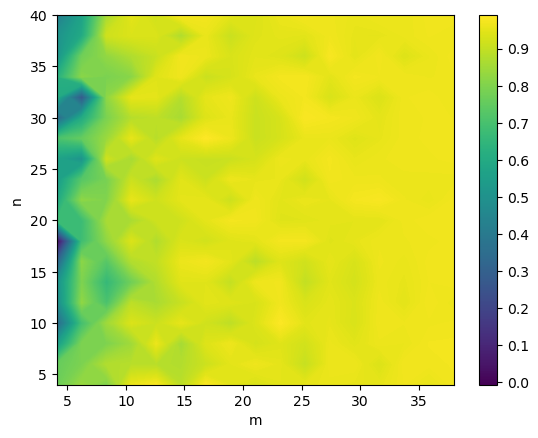

In [134]:
x = np.linspace(2,38,18)

x

y = np.linspace(2,40,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2_a[level:,level:,0],origin='lower',levels=500)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()